In [2]:
from google.colab import files
uploaded = files.upload()

Saving Tabela-2.22-_Pobr_Geo_.csv to Tabela-2.22-_Pobr_Geo_ (1).csv
Saving estimativa_dou_2025.csv to estimativa_dou_2025 (1).csv
Saving Bolsa_Fam_mais_que_meio_sal_min.csv to Bolsa_Fam_mais_que_meio_sal_min (1).csv
Saving Bolsa_Fam_baixa_renda.csv to Bolsa_Fam_baixa_renda (1).csv
Saving Bolsa_Fam_extrema_pobreza.csv to Bolsa_Fam_extrema_pobreza (1).csv


In [3]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual dos gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


In [21]:
# Leitura dos arquivos CSV

df_meio_sal = pd.read_csv('Bolsa_Fam_mais_que_meio_sal_min.csv', sep=',')
df_baixa_renda = pd.read_csv('Bolsa_Fam_baixa_renda.csv', sep=',')
df_pobreza = pd.read_csv('Bolsa_Fam_extrema_pobreza.csv', sep=',')
df_



In [47]:
# Padronização nome das colunas
def padroniza_colunas(df):
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(' ', '_')
                  .str.replace('ã', 'a')
                  .str.replace('ç', 'c'))
    return df

df_meio_sal = padroniza_colunas(df_meio_sal)
df_baixa_renda = padroniza_colunas(df_baixa_renda)
df_pobreza = padroniza_colunas(df_pobreza)


In [57]:
# Alterar nomes das colunas
df_baixa_renda = df_baixa_renda.rename(columns={'quantidade_de_pessoas_em_famílias_de_baixa_renda**_beneficiárias_do_programa_bolsa_família': 'benef_baixa_renda'})
df_pobreza = df_pobreza.rename(columns={'quantidade_de_pessoas_em_famílias_beneficiárias_do_programa_bolsa_família_em_situacao_de_pobreza,_segundo_a_faixa_do_programa*': 'benef_pobreza'})
df_meio_sal = df_meio_sal.rename(columns={'quantidade_de_pessoas_em_famílias_com_renda_per_capita_mensal_acima_de_meio_salário-mínimo***_beneficiárias_do_programa_bolsa_família' :'benef_meio_salario'})

# Junção completa por estado
bolsa = (df_baixa_renda
         .merge(df_pobreza[['código', 'nome', 'benef_pobreza']], on=['código', 'nome'], how='outer')
         .merge(df_meio_sal[['código', 'nome', 'benef_meio_salario']], on=['código', 'nome'], how='outer'))

# Convert beneficiary columns to numeric, handling potential errors and thousands separators
bolsa['benef_baixa_renda'] = pd.to_numeric(bolsa['benef_baixa_renda'].astype(str).str.replace('.', '', regex=False), errors='coerce')
bolsa['benef_pobreza'] = pd.to_numeric(bolsa['benef_pobreza'].astype(str).str.replace('.', '', regex=False), errors='coerce')
bolsa['benef_meio_salario'] = pd.to_numeric(bolsa['benef_meio_salario'].astype(str).str.replace('.', '', regex=False), errors='coerce')


# Cria coluna total de beneficiários
bolsa['benef_total'] = (bolsa['benef_baixa_renda'].fillna(0) +
                        bolsa['benef_pobreza'].fillna(0) +
                        bolsa['benef_meio_salario'].fillna(0))

bolsa.drop(columns=['benef_meio_salario', 'código'], inplace=True) # Remover as colunas de "benf_meio_salario" pois todos os valores estavam nulos e "código" pois os valores não importam para nossa análise.
bolsa.head()





/tmp/ipython-input-3573198351.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='nome', y='benef_total', data=bolsa, palette='viridis')


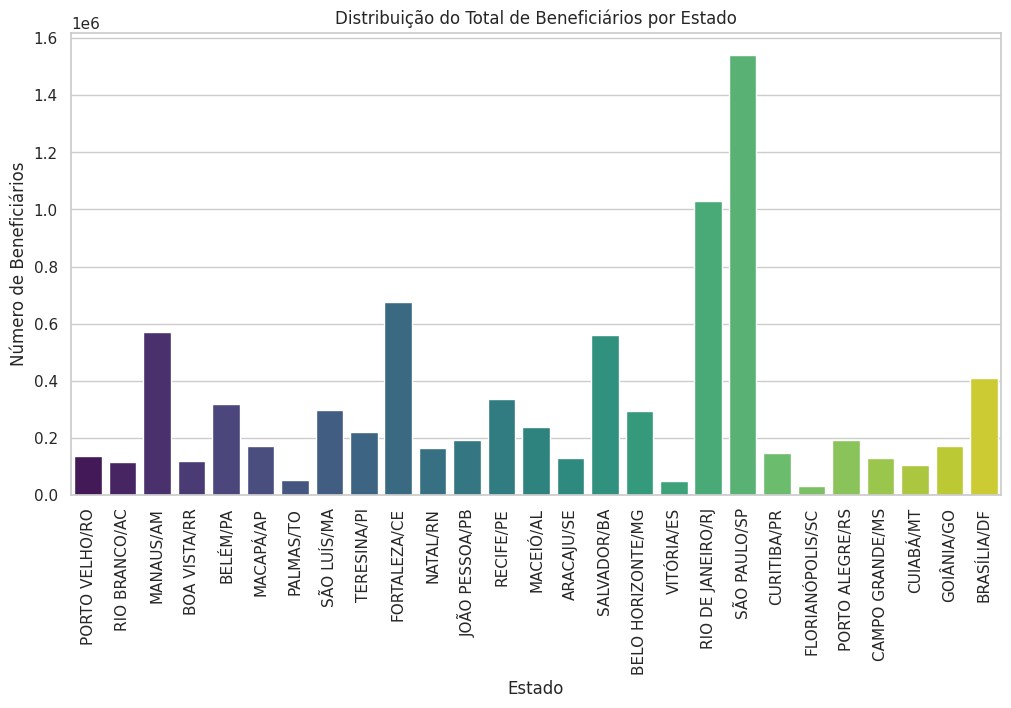

In [59]:
# Gráfico de distribuição por estado
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de barras do total de beneficiários
plt.figure(figsize=(12,6))
sns.barplot(x='nome', y='benef_total', data=bolsa, palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribuição do Total de Beneficiários por Estado')
plt.ylabel('Número de Beneficiários')
plt.xlabel('Estado')
plt.show()

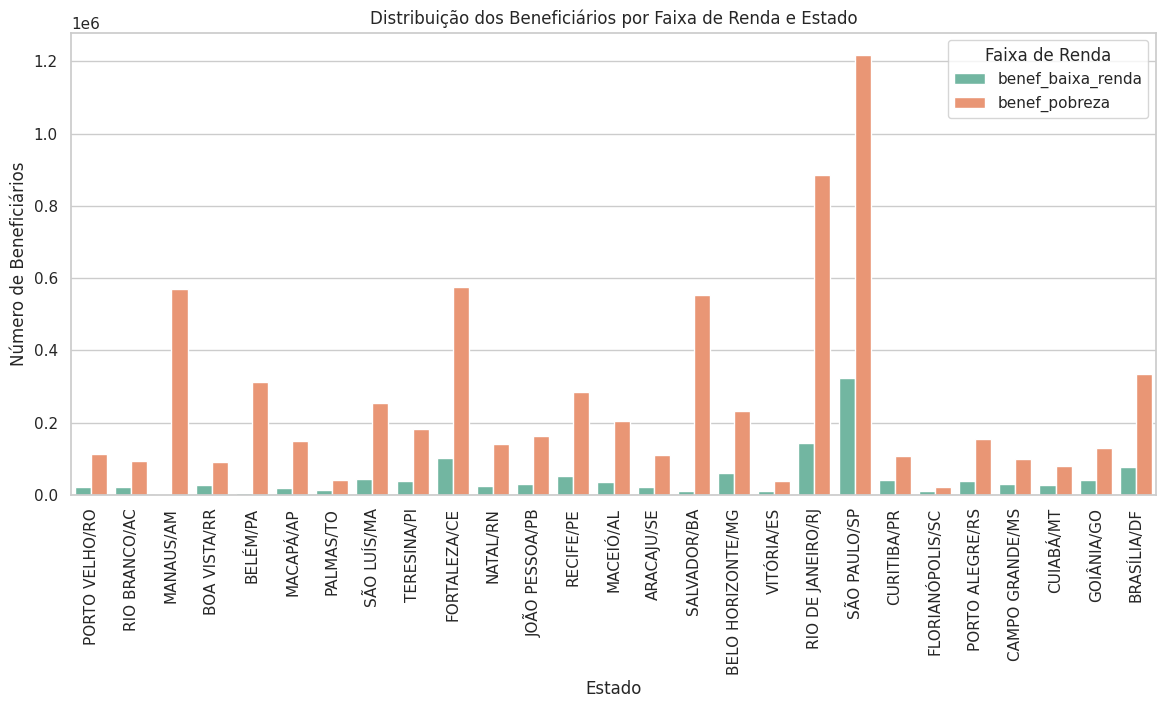

In [61]:
# Transformar o DataFrame no formato long
df_melt = bolsa.melt(id_vars=['nome'],
                     value_vars=['benef_baixa_renda', 'benef_pobreza'],
                     var_name='faixa_renda',
                     value_name='beneficiarios')

# Gráfico de barras agrupadas
plt.figure(figsize=(14,6))
sns.barplot(x='nome', y='beneficiarios', hue='faixa_renda', data=df_melt, palette='Set2')
plt.xticks(rotation=90)
plt.title('Distribuição dos Beneficiários por Faixa de Renda e Estado')
plt.ylabel('Número de Beneficiários')
plt.xlabel('Estado')
plt.legend(title='Faixa de Renda')
plt.show()

In [63]:
df_estimativa_populacao = pd.read_csv('estimativa_dou_2025.csv', header=1, sep=',')

# Selecionar as duas primeiras colunas e renomear
df_estimativa_populacao = df_estimativa_populacao.iloc[:, :2]
df_estimativa_populacao.columns = ['nome_do_estado', 'populacao_estimada']

# Remover as duas primeiras fileiras e as últimas 5 fileiras
df_estimativa_populacao = df_estimativa_populacao.iloc[2:-5].copy()

# Limpar a coluna 'populacao_estimada' e converta para numérico
df_estimativa_populacao['populacao_estimada'] = (df_estimativa_populacao['populacao_estimada']
                                                 .astype(str)
                                                 .str.replace(',', '', regex=False)
                                                 .str.replace(r'\(.*\)', '', regex=True) # Remover conteúdo entre parênteses
                                                 .str.strip() # Remover espaços em branco iniciais/finais
                                                 )
df_estimativa_populacao['populacao_estimada'] = pd.to_numeric(df_estimativa_populacao['populacao_estimada'], errors='coerce')

display(df_estimativa_populacao.head())
display(df_estimativa_populacao.info())

,nome_do_estado,populacao_estimada
2,Rondônia,1751950
3,Acre,884372
4,Amazonas,4321616
5,Roraima,738772
6,Pará,8711196


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 2 to 31
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   nome_do_estado      30 non-null     object
 1   populacao_estimada  30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 612.0+ bytes


None

In [64]:
# Mesclar os quadros de dados
bolsa_merged = pd.merge(bolsa, df_estimativa_populacao, left_on='nome', right_on='nome_do_estado', how='left')

# Exibir as primeiras linhas do DataFrame mesclado
display(bolsa_merged.head())

,nome,referência,benef_baixa_renda,benef_pobreza,benef_total,nome_do_estado,populacao_estimada
0,PORTO VELHO/RO,09/2025,21454,112769,134223.0,NaN,NaN
1,RIO BRANCO/AC,09/2025,21038,93138,114176.0,NaN,NaN
2,MANAUS/AM,09/2025,1020,568763,569783.0,NaN,NaN
3,BOA VISTA/RR,09/2025,26539,90769,117308.0,NaN,NaN
4,BELÉM/PA,09/2025,3831,313276,317107.0,NaN,NaN


In [65]:
display(bolsa['nome'].unique())

array(['PORTO VELHO/RO', 'RIO BRANCO/AC', 'MANAUS/AM', 'BOA VISTA/RR',
       'BELÉM/PA', 'MACAPÁ/AP', 'PALMAS/TO', 'SÃO LUÍS/MA', 'TERESINA/PI',
       'FORTALEZA/CE', 'NATAL/RN', 'JOÃO PESSOA/PB', 'RECIFE/PE',
       'MACEIÓ/AL', 'ARACAJU/SE', 'SALVADOR/BA', 'BELO HORIZONTE/MG',
       'VITÓRIA/ES', 'RIO DE JANEIRO/RJ', 'SÃO PAULO/SP', 'CURITIBA/PR',
       'FLORIANÓPOLIS/SC', 'PORTO ALEGRE/RS', 'CAMPO GRANDE/MS',
       'CUIABÁ/MT', 'GOIÂNIA/GO', 'BRASÍLIA/DF'], dtype=object)

In [66]:
#Extrair as iniciais do estado de 'nome' e criar uma nova coluna 'estado_sigla'
bolsa['estado_sigla'] = bolsa['nome'].apply(lambda x: x.split('/')[-1])

# Criar um mapeamento das iniciais dos estados para os nomes completos dos estados
state_mapping = {
    'RO': 'Rondônia', 'AC': 'Acre', 'AM': 'Amazonas', 'RR': 'Roraima',
    'PA': 'Pará', 'AP': 'Amapá', 'TO': 'Tocantins', 'MA': 'Maranhão',
    'PI': 'Piauí', 'CE': 'Ceará', 'RN': 'Rio Grande do Norte',
    'PB': 'Paraíba', 'PE': 'Pernambuco', 'AL': 'Alagoas', 'SE': 'Sergipe',
    'BA': 'Bahia', 'MG': 'Minas Gerais', 'ES': 'Espírito Santo',
    'RJ': 'Rio de Janeiro', 'SP': 'São Paulo', 'PR': 'Paraná',
    'SC': 'Santa Catarina', 'RS': 'Rio Grande do Sul', 'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso', 'GO': 'Goiás', 'DF': 'Distrito Federal' # DF = mapeia pro Distrito Federal
}

# Mapear iniciais de estados para nomes completos de estados em 'bolsa'
bolsa['nome_do_estado'] = bolsa['estado_sigla'].map(state_mapping)

# Mesclar os dataframes usando a nova coluna 'nome_do_estado'
bolsa_merged = pd.merge(bolsa, df_estimativa_populacao, on='nome_do_estado', how='left')

display(bolsa_merged.head())

,nome,referência,benef_baixa_renda,benef_pobreza,benef_total,estado_sigla,nome_do_estado,populacao_estimada
0,PORTO VELHO/RO,09/2025,21454,112769,134223.0,RO,Rondônia,1751950.0
1,RIO BRANCO/AC,09/2025,21038,93138,114176.0,AC,Acre,884372.0
2,MANAUS/AM,09/2025,1020,568763,569783.0,AM,Amazonas,4321616.0
3,BOA VISTA/RR,09/2025,26539,90769,117308.0,RR,Roraima,738772.0
4,BELÉM/PA,09/2025,3831,313276,317107.0,PA,Pará,8711196.0


In [67]:
# Calcular o percentual da população beneficiada pelo Bolsa Família
bolsa_merged['perc_populacao_beneficiada'] = (bolsa_merged['benef_total'] / bolsa_merged['populacao_estimada']) * 100
display(bolsa_merged.head())

,nome,referência,benef_baixa_renda,benef_pobreza,benef_total,estado_sigla,nome_do_estado,populacao_estimada,perc_populacao_beneficiada
0,PORTO VELHO/RO,09/2025,21454,112769,134223.0,RO,Rondônia,1751950.0,7.661349
1,RIO BRANCO/AC,09/2025,21038,93138,114176.0,AC,Acre,884372.0,12.910404
2,MANAUS/AM,09/2025,1020,568763,569783.0,AM,Amazonas,4321616.0,13.184489
3,BOA VISTA/RR,09/2025,26539,90769,117308.0,RR,Roraima,738772.0,15.878783
4,BELÉM/PA,09/2025,3831,313276,317107.0,PA,Pará,8711196.0,3.640223


/tmp/ipython-input-3742410967.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='nome_do_estado', y='perc_populacao_beneficiada', data=bolsa_merged, palette='coolwarm')


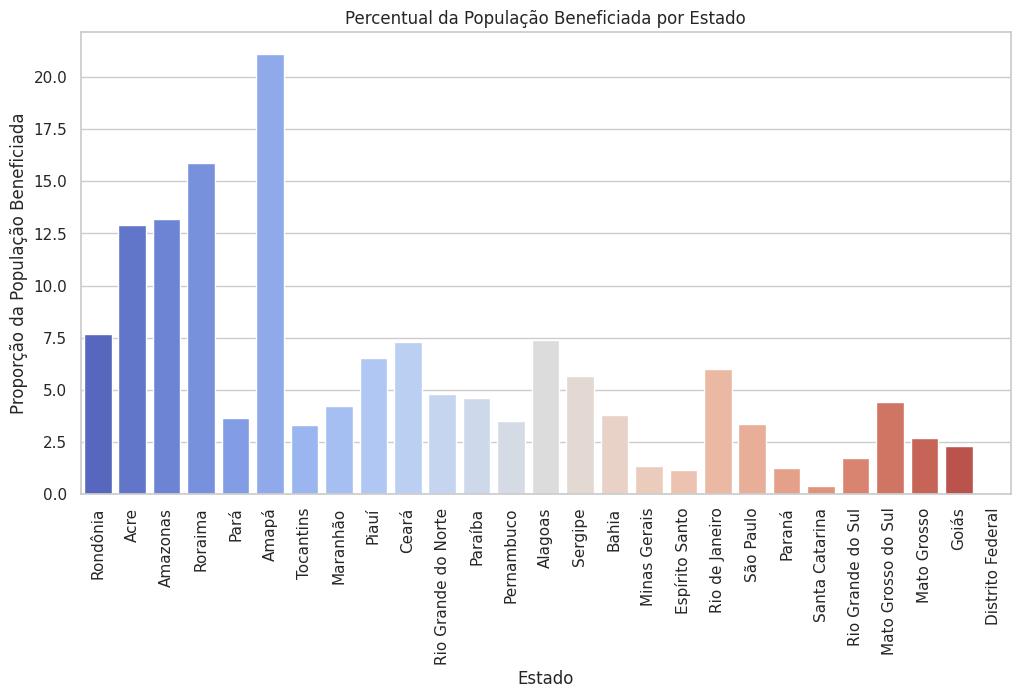

In [68]:
plt.figure(figsize=(12, 6))
sns.barplot(x='nome_do_estado', y='perc_populacao_beneficiada', data=bolsa_merged, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Percentual da População Beneficiada por Estado')
plt.ylabel('Proporção da População Beneficiada')
plt.xlabel('Estado')
plt.show()